In [2]:
import networkx as nx
import numpy as np
import sys, os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
class Graph:
  def __init__(self, filename):
    self.G = nx.read_edgelist(filename,nodetype=int)
    self.list = [list(nbrdict.keys()) for _, nbrdict in self.G.adjacency()]
    arr = ((np.array(nx.degree(self.G)).astype(int)))
    arr = arr[arr[:, 0].argsort()]
    self.degree = list(arr[:,1])
    
  
  def get_p_i(self):
    ''' 
    @return the degree density distribution as a vector
    where index are degree and values are frequency
    '''
    arr = [self.degree.count(d) for d in range(max(self.degree)+1)] 
    return np.array(arr) / len(self.G.nodes)
    
  def get_p_ij(self):  
    ''' 
    @return the transition probability between nodes of degree i and nodes of degree j
    for all possible i, j between 0 and max degree
    '''
    max_d = max(self.degree)
    degree = np.array(self.degree)
    p_ij = np.zeros((max_d+1,max_d+1))
    for i in range(max_d+1):
      # get all nodes with degree i
      di = np.where(degree==i)[0]
      if len(di) == 0:
        continue
      neighbors = []
      for node in di:
        neighbors += self.list[node]
      neighbors = (list(set(neighbors)))
      degrees_of_neighbors = degree[neighbors]
      unique, counts = np.unique(degrees_of_neighbors, return_counts=True)
      # print(i,"uniq",unique, "cnt",counts)
      for pos in range(len(unique)):
        d = unique[pos]
        p_ij[i,d] = counts[pos] / len(neighbors)
    # print(p_ij)
    return p_ij
  
  def compute_amplification(self):
    '''compute the amplification factor in a Moran birth-death model
    '''
    p_i = self.get_p_i() # is a vector
    # print(p_i)
    p_ij = self.get_p_ij() # is a numpy matrix
    term1, term2 = 0.0, 0.0
    for i in range(len(p_i)):
      for j in range(len(p_i)):
        if p_i[i] * p_ij[i,j] == 0:
          continue
        term1 += p_i[i] * p_ij[i,j] * (1/j)
        term2 += p_i[i] * p_ij[i,j] / (j**2)
    alpha = get_first_inverse(p_i) * term1 * (1/term2)
    # print(alpha)
    return alpha
  
  def compute_mixing_pattern(self):
    '''compute the assortativity coefficient of a grpah
    '''
    return nx.degree_assortativity_coefficient(self.G)
  
  def get_n_triangles(self):
    triangle_list = list(nx.triangles(self.G).values())
    return sum(triangle_list) / 3
  
  def show(self):
    nx.draw_networkx(self.G)
    plt.show()
  
  def remove_a_bridge(self):
    # print(nx.degree(self.G))
    degrees = self.degree
    max_d = max(degrees)
    min_d = min(degrees)
    for (u,v) in self.G.edges():
      u,v = int(u),int(v)
      if (degrees[u] == min_d+1 and degrees[v] > min_d) or \
          (degrees[v] == min_d+1 and degrees[u] > min_d):
        self.G.remove_edge(str(u), str(v))
        degrees = list((np.array(nx.degree(self.G)).astype(int))[:,1])
        # print(degrees)
        return
    print("Failed to remove edge")
    return
   
  def writetofile(self, output):
    nx.write_edgelist(self.G, output, data=False)


In [16]:
def plot_dir(dirname, result_dirname, xlabel, line=False, color_on=False):
  n = len(os.listdir(f"{result_dirname}1"))
  xs = np.zeros((n,))
  ys = np.zeros((n,))
  degs = np.zeros((n,))
  color = np.zeros((n,)) # amplification factor or whatever it is
  for rep in range(1,6):
    result_dir = f"{result_dirname}{rep}"
    for filename in os.listdir(result_dir):
      f = (os.path.join(result_dir,filename))
      # print(f)
      id = int(filename.split(".")[0])
      if os.stat(f).st_size == 0:
        print(id, "file is empty")
        continue
      data = pd.read_csv(f, sep='\t', header=None)
      graphfile = f"{dirname}{id}.txt"
      xs[id%n] += (data.iloc[0,4])
      ys[id%n] += (data.iloc[1,4])
      g = Graph(graphfile)
      degrees = g.degree
      # print(degrees)
      degs[id%n] =  abs(degrees[98] - degrees[2]) #
      color[id%n] = degrees[5] # sum(nx.triangles(g.G).values()) / 3# get_size(id%n) # nx.transitivity(g.G) # g.compute_amplification()
      # g.show()
  ratio = np.divide(np.array(ys),np.array(xs))
  mask = np.isfinite(ratio)
  x_axis = degs # [i for i in range(len(ratio))]
  # print(x_axis)
  if color_on:
      colors = color
  else: colors=None
  # 
  if line:
    df = pd.DataFrame({f"{sys.argv[1]}":x_axis,"pfix_max_variance / pfix_0_variance":ratio})
    g = sns.lmplot(x=sys.argv[1], y="pfix_max_variance / pfix_0_variance", data=df)
  else: plt.scatter(x_axis,ratio,c=colors)
  plt.gca().set(title="", xlabel=xlabel, ylabel="ratio of pfix_max_variance / pfix_0_variance")
  if color_on: plt.colorbar()

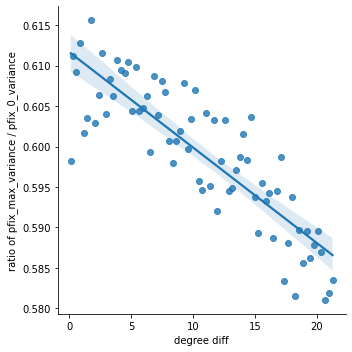

In [9]:
name = "90_10_deg_diff_3reg"
dirname = f"./graphs/{name}/"
result_dirname = f"./graphs/res_{name}"
plot_dir(dirname, result_dirname, "degree diff", line=True)

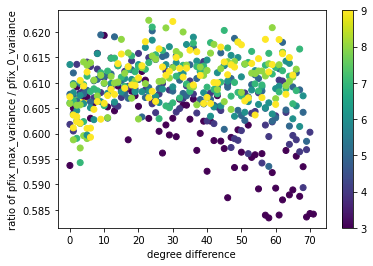

In [17]:
name = "90_10_deg_diff"
dirname = f"./graphs/{name}/"
result_dirname = f"./graphs/res_{name}"
plot_dir(dirname, result_dirname, "degree difference", line=False, color_on=True)

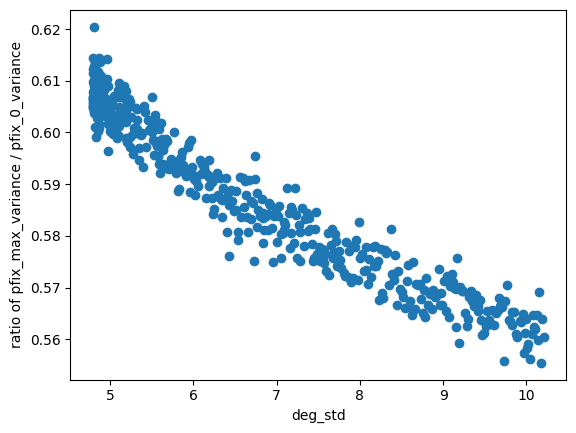

In [28]:
name = "star_regular_center"
xlabel = "deg_std"
dirname = f"./graphs/{name}/"
result_dirname = f"./graphs/res_{name}"
plot_dir(dirname, result_dirname, xlabel)

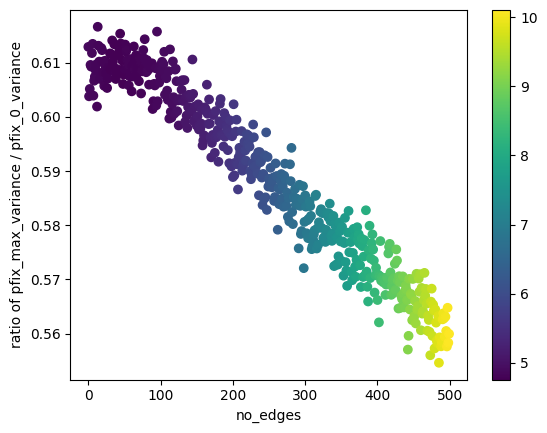

In [17]:
name = "star_wheel_center"
xlabel = "no_edges"
dirname = f"./graphs/{name}/"
result_dirname = f"./graphs/res_{name}"
plot_dir(dirname, result_dirname, xlabel)

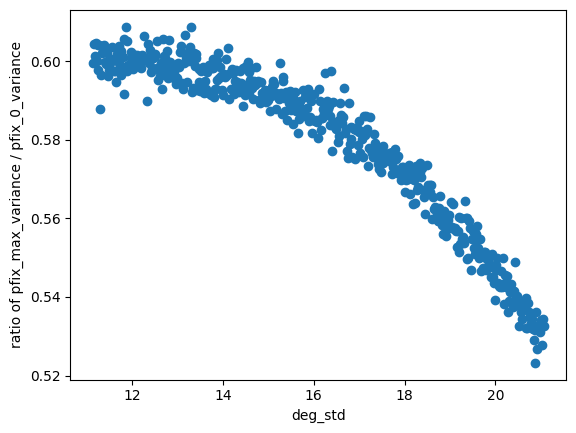

In [29]:
name = "star_regular_43reg"
xlabel = "deg_std"
dirname = f"./graphs/{name}/"
result_dirname = f"./graphs/res_{name}"
plot_dir(dirname, result_dirname, xlabel)